<a href="https://colab.research.google.com/github/esterfb3397/fake-news-project-tfm/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string 
import re 
import csv

import scipy.stats as stats
#import warnings
#warnings.filterwarnings('error')
from tqdm.autonotebook import tqdm
tqdm.pandas()

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report

<ipython-input-2-80e687d9469f>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [1]:
#Acceso al repo
!git clone https://github.com/esterfb3397/fake-news-project-tfm.git

Cloning into 'fake-news-project-tfm'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 38 (delta 26), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), 6.28 MiB | 5.13 MiB/s, done.


# Obtención del corpus

Este dataset viene de la página https://www.uvic.ca/ecs/ece/isot/datasets/fake-news/index.php. 
Está dividido en dos conjuntos de datos: real y fake. Los datos de real se recopilaron a partir de fuentes del mundo real a partir de noticias seleccionadas de  la página Reuter. En cambio, las fake news  procedían de sitios web poco fiables marcados por Politifact (una organización de comprobación de hechos de EE.UU.) y Wikipedia.
de EE.UU.) y Wikipedia. El conjunto de datos contiene distintos tipos de artículos sobre diferentes temas.
Sin embargo, la mayoría de los artículos se centran en noticias políticas y mundiales. 



Nos traemos de local los dos dataset


In [3]:
fake = pd.read_excel('/content/Fake.xlsx')
real = pd.read_excel('/content/True.xlsx')

Vemos que se han importado correctamente

In [4]:
print(fake.shape,real.shape)

(23481, 4) (21417, 4)


In [5]:
fake.head(2)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"


In [6]:
real.head(2)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


Tenemos que juntar el dataframe por lo que primero habrá que crear una nueva columna para ver si es fake news o no. En caso afirmativo la columna tendrá valor de 1 (fake news) y para las real news tendrá un valor de 0.

In [7]:
fake.insert(4, 'label', '1')

In [8]:
fake.head(2)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1


In [9]:
real.insert(4, 'label', '0')

In [10]:
real.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0


Antes de juntarlo vemos que en la columna text hay varios reuters con el nombre de una ciudad + reuters, cosa que vamos a cambiar


In [11]:
#Primero creamos una lista de los que no han publicado
unknown_publishers = []
for index,row in enumerate(real.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #si la parte del texto no está dará error
        record[1]
        #si la longitud de texto es inferior a 260 dara error y se asegurara de no tener - para que no se cuente
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [12]:
#Separamos informacion de quien ha publicado y de quien no se menciona
publisher = []
tmp_text = []
for index,row in enumerate(real.text.values):
    if index in unknown_publishers:
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [13]:
#Reemplazamos la columna text con una nueva columna añadiendo una nueva con la info de publicacion

real["publisher"] = publisher
real["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [14]:
real.head(2)

,title,text,subject,date,label,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",0,WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",0,WASHINGTON (Reuters)


In [15]:
real = real.drop(['publisher'],axis = 1)

Ahora juntamos unimos fake y real en un solo dataframe.

In [16]:
df = pd.concat([real,fake])


In [17]:
df.head(2)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",0


In [18]:
df.tail(2)

,title,text,subject,date,label
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",1
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",1


Ya que hemos juntado los dos df, vamos a juntar las variables title y text en una nueva llamada como title_text

In [19]:
df['title_text']= df.title.str.cat(df.text, sep=' ')

Ahora quitamos las columnas que no nos hacen falta y reordenamos las que tenemos.

In [20]:
df = df.drop(['title', 'text','date','subject'], axis=1)

In [21]:
df

,label,title_text
0,0,"As U.S. budget fight looms, Republicans flip t..."
1,0,U.S. military to accept transgender recruits o...
2,0,Senior U.S. Republican senator: 'Let Mr. Muell...
3,0,FBI Russia probe helped by Australian diplomat...
4,0,Trump wants Postal Service to charge 'much mor...
...,...,...
23476,1,McPain: John McCain Furious That Iran Treated ...
23477,1,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
23478,1,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
23479,1,How to Blow $700 Million: Al Jazeera America F...


#Estudio del df

* **Número de documentos y columnas:**

Comenzamos mostrando el número de documentos, o lo que es lo mismo, el número de filas del data frame:

In [22]:
#Primero comprobamos el tamaño y las columnas
print(len(df))
print(df.shape[1])

44898
2


* **Número de documentos duplicados:**

Despues, comprobamos y eliminamos las filas con algún valor vacío (NA) y quitaremos los duplicados

In [23]:
np.sum(df.duplicated())

5794

Como han salido filas duplicadas, las tenemos que limpiar

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
np.sum(df.duplicated())

0

Como ya se han tratado las filas con duplicados.Comprobaramos que no hayan quedado Nulls en ningunas de las columnas del dataset

In [26]:
print(np.sum(df.isnull()))

label         0
title_text    0
dtype: int64


Vemos como ha aquedado el df después de las modificaciones

In [27]:
df.shape

(39104, 2)

* **Número de documentos por cada clase:**

Contamos el número de elementos de cada clase, esto se hace muy fácil con un groupby de la columna 'positive' y un conteo posterior. También se puede hacer con un value_counts sobre la serie de la etiqueta.

In [28]:
df['label'].value_counts()

0    21196
1    17908
Name: label, dtype: int64

A primer vistazo podemos observar que está bastante balanceado

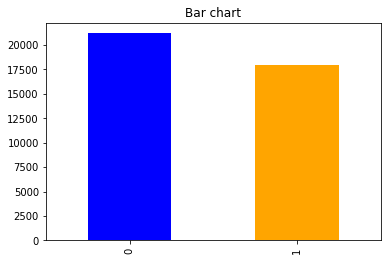

In [29]:
ax, fig = plt.subplots()
etiquetas = df['label'].value_counts()
etiquetas.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

Podemos concluir que el dataset está balanceado aunque las fake news son menos que las real news

* **Distribución de la longitud de los tweet en caracteres:**


Para seguir con el análisis exploratorio, vamos a hacer un cálculo típico: la longitud de cada uno de los textos de los documentos para despues dibujar su histograma. 

Comenzamos creando las columnas que van a almacenar las longitud en caracteres y en tokens de los documentos del corpus:

In [30]:
df['length'] = df['title_text'].apply(lambda x: len(x))

In [31]:
df.head(2)

,label,title_text,length
0,0,"As U.S. budget fight looms, Republicans flip t...",4702
1,0,U.S. military to accept transgender recruits o...,4120


En clase, se ha realizado el código de a continuación para poder visualizar mejor la distribucion de la longitud de las noticias en caracteres

Para la realizacion de este gráfico vamos a ver qué tipo de datos estamos trabajando ya que tendremos que pasar la variable label como int

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39104 entries, 0 to 22702
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       39104 non-null  object
 1   title_text  39104 non-null  object
 2   length      39104 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [33]:
df['label']= df['label'].astype(int)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


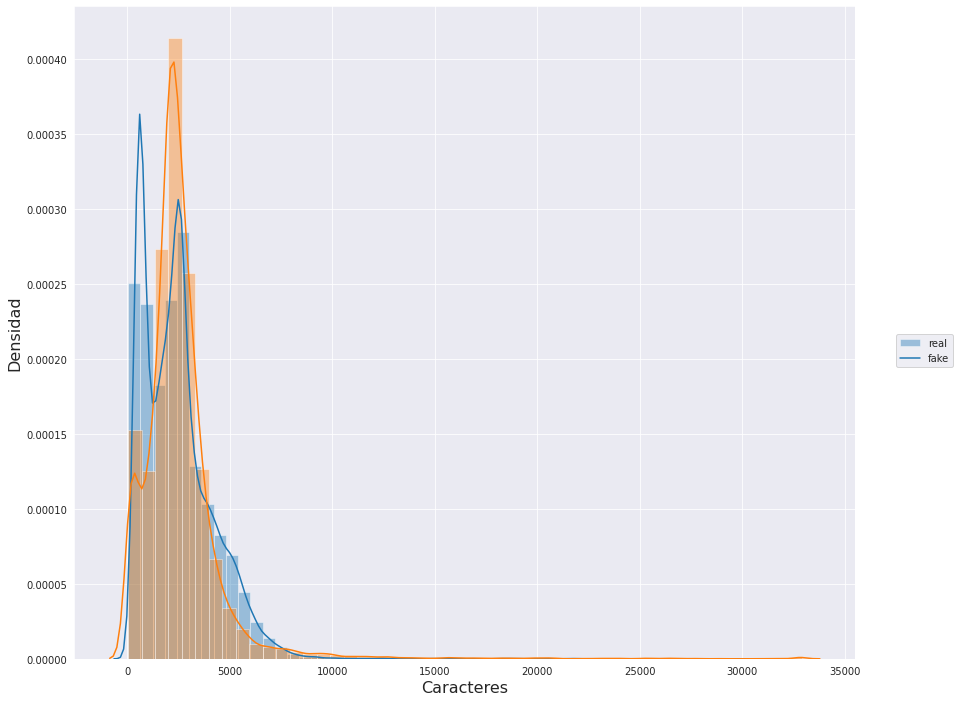

In [34]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(df[df.label==0].length, hist=True, label="real")
plt2 = sns.distplot(df[df.label==1].length, hist=True, label="fake")
fig.legend(labels=['real','fake'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

 Vemos que las distribuciones de longitud de los titulares y el texto llevan una distribucion similar,aunque la distribucion de las noticias falsas parecen tener outliers. 

In [35]:
# Calcular número de palabras por documento
df["nwords"] = df["title_text"].apply(lambda s: len(s.split(" ")))


In [36]:
df['nwords'].describe()

count    39104.000000
mean       418.951898
std        317.104606
min          2.000000
25%        224.000000
50%        386.000000
75%        533.000000
max       5659.000000
Name: nwords, dtype: float64

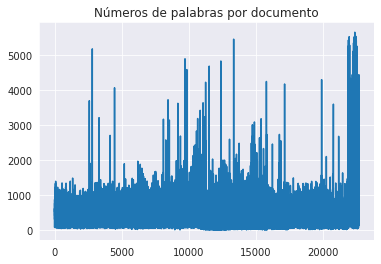

In [37]:
fig, ax = plt.subplots()
ax.set_title('Números de palabras por documento')
ax.plot(df['nwords'])


In [38]:
# Calcular media de caracteres por palabra
df["avg_char_word"] = df["title_text"].apply(lambda s: len(s) / len(s.split(" ")))
df.head(2)

,label,title_text,length,nwords,avg_char_word
0,0,"As U.S. budget fight looms, Republicans flip t...",4702,761,6.178712
1,0,U.S. military to accept transgender recruits o...,4120,632,6.518987


In [39]:
df['avg_char_word'].describe()

count    39104.000000
mean         5.970257
std          1.249230
min          1.751743
25%          5.738367
50%          5.949345
75%          6.162955
max        149.500000
Name: avg_char_word, dtype: float64

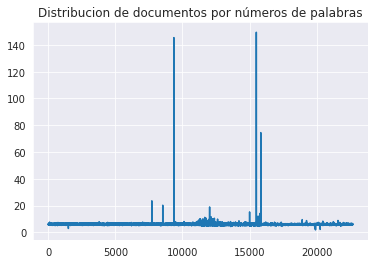

In [40]:
fig, ax = plt.subplots()
ax.set_title('Distribucion de documentos por números de palabras')
ax.plot(df['avg_char_word'])

In [41]:
# Calcular número de palabras distintas
df["n_distint_word"] = df["title_text"].apply(lambda s: len(set(s.split(" "))))
df

,label,title_text,length,nwords,avg_char_word,n_distint_word
0,0,"As U.S. budget fight looms, Republicans flip t...",4702,761,6.178712,424
1,0,U.S. military to accept transgender recruits o...,4120,632,6.518987,338
2,0,Senior U.S. Republican senator: 'Let Mr. Muell...,2828,474,5.966245,257
3,0,FBI Russia probe helped by Australian diplomat...,2499,384,6.507812,236
4,0,Trump wants Postal Service to charge 'much mor...,5244,873,6.006873,452
...,...,...,...,...,...,...
22698,1,The White House and The Theatrics of ‘Gun Cont...,7410,1300,5.700000,635
22699,1,Activists or Terrorists? How Media Controls an...,26365,4443,5.934054,1771
22700,1,"BOILER ROOM – No Surrender, No Retreat, Heads ...",1216,204,5.960784,156
22701,1,Federal Showdown Looms in Oregon After BLM Abu...,20747,3540,5.860734,1315


In [52]:
df["n_distint_word"].describe()

count    32144.000000
mean       260.159190
std        137.322395
min         53.000000
25%        181.000000
50%        242.000000
75%        314.000000
max       2315.000000
Name: n_distint_word, dtype: float64

In [54]:
#Vamos a quitar las palabras que caigan en el percentil de 10% ya que 
df["nwords"].describe(percentiles=[0.10])

count    32144.000000
mean       460.244774
std        313.022544
min         93.000000
20%        252.000000
50%        408.000000
max       5659.000000
Name: nwords, dtype: float64

In [43]:
df[df['nwords'] <= 92.0].sort_values(by = 'nwords',ascending = True).head(20)

,label,title_text,length,nwords,avg_char_word,n_distint_word
15507,1,https://100percentfedup.com/video-hillary-aske...,177,2,88.500000,1
15508,1,https://100percentfedup.com/12-yr-old-black-co...,299,2,149.500000,1
15840,1,https://fedup.wpengine.com/wp-content/uploads/...,133,2,66.500000,1
15839,1,https://fedup.wpengine.com/wp-content/uploads/...,149,2,74.500000,1
9358,1,https://100percentfedup.com/served-roy-moore-v...,291,2,145.500000,1
8970,0,Graphic: Supreme Court roundup,32,6,5.333333,5
11854,1,LIVE FEED: INAUGURATION 2017!,31,6,5.166667,5
11117,1,MY FAVORITE EXCUSES…Featuring Hillary Rotten C...,67,8,8.375000,8
12038,1,WHERE’S HILLARY? CLINTON SPOTTED Dining Alone,47,8,5.875000,7
11900,1,WATCH Life Accordion To Trump! [VIDEO],40,8,5.000000,7


In [44]:
df = df.drop(df[df['nwords'] <= 92.0].index)

In [45]:
df.shape

(32144, 6)

In [46]:
df['label'].value_counts()

0    17552
1    14592
Name: label, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


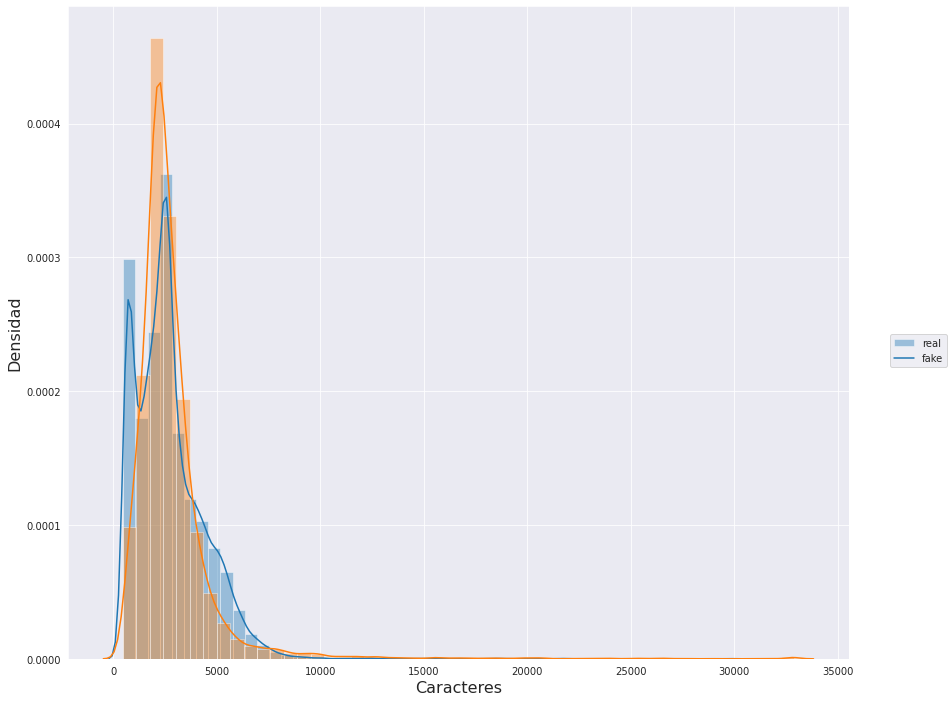

In [47]:
fig = plt.figure(figsize=(14,12))
sns.set_style("darkgrid")
# añadimos series para cada categoría (eligiendo la seríe de char_len
plt1 = sns.distplot(df[df.label==0].length, hist=True, label="real")
plt2 = sns.distplot(df[df.label==1].length, hist=True, label="fake")
fig.legend(labels=['real','fake'], loc = 5)


# Definimos el título de los ejes:
plt.xlabel('Caracteres', fontsize=16)
plt.ylabel('Densidad', fontsize=16)

# Finalmente mostramos el gráfico:
plt.show()

In [48]:
df['length'].describe()

count    32144.000000
mean      2739.942446
std       1876.640076
min        451.000000
25%       1718.000000
50%       2430.000000
75%       3318.000000
max      32887.000000
Name: length, dtype: float64

In [49]:
# for x in ['nwords']:
#     q75,q25 = np.percentile(df.loc[:,x],[75,25])
#     intr_qr = q75-q25
 
#     max = q75+(1.5*intr_qr)
#     min = q25-(1.5*intr_qr)
 
#     df.loc[df[x] < min,x] = np.nan
#     df.loc[df[x] > max,x] = np.nan


In [50]:
# df.isnull().sum() se limpiaria la parte null y es otra forma de hacerlo

In [51]:
#Exportamos el df clean y montado
df.to_excel('/content/fake-news-project-tfm/data/clean_data.xlsx',index = False)

FileNotFoundError: ignored

In [ ]:
import pickle
with open("df.pickle", "wb") as file:
    # Serialize and save the object to the file
    pickle.dump(df, file)
